In [186]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Configuración warnings
# ==============================================================================
import warnings
#warnings.filterwarnings('ignore')

In [33]:
_ = !pip install skforecast

In [187]:
# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

In [200]:
# Descarga de datos
# ==============================================================================
from datetime import datetime
import yfinance as yf

stocks = ["BTC-USD"]
start = '2021-01-01'
end = datetime.now()
data = yf.download(stocks, start=start, end=end)
d1 = data.copy()

[*********************100%***********************]  1 of 1 completed


In [201]:
d1.describe()

,Open,High,Low,Close,Adj Close,Volume
count,389.000000,389.000000,389.000000,389.000000,389.000000,3.890000e+02
mean,47102.999162,48417.353596,45575.222194,47108.464984,47108.464984,4.621549e+10
std,9633.744300,9662.124390,9599.044981,9601.065250,9601.065250,2.447710e+10
min,28994.009766,29600.626953,28722.755859,29374.152344,29374.152344,1.790210e+10
25%,38392.625000,39952.296875,36491.191406,38402.222656,38402.222656,3.174426e+10
50%,47261.406250,48450.468750,46347.476562,47178.125000,47178.125000,3.950807e+10
75%,55947.898438,57482.167969,53735.144531,55950.746094,55950.746094,5.724420e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


In [202]:
import pandas as pd
datos= d1.copy()
datos.reset_index(level=0, inplace=True)
datos['Date'] = pd.to_datetime(datos['Date'])
datos = datos.set_index('Date')
#datos.set_axis(datos['Date'], inplace=True)
#datos.drop(columns=['Open', 'Date','High', 'Low', 'Volume'], inplace=True)
#datos.reset_index(level=0, inplace=True)
datos = datos.rename(columns={'Close': 'y'})
datos = datos.asfreq('1D')
datos = datos.sort_index()
datos.head()

,Open,High,Low,y,Adj Close,Volume
Date,,,,,,
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,4.073030e+10
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,6.786542e+10
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,7.866524e+10
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,8.116348e+10
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,6.754732e+10


In [203]:
datos.describe()

,Open,High,Low,y,Adj Close,Volume
count,389.000000,389.000000,389.000000,389.000000,389.000000,3.890000e+02
mean,47102.999162,48417.353596,45575.222194,47108.464984,47108.464984,4.621549e+10
std,9633.744300,9662.124390,9599.044981,9601.065250,9601.065250,2.447710e+10
min,28994.009766,29600.626953,28722.755859,29374.152344,29374.152344,1.790210e+10
25%,38392.625000,39952.296875,36491.191406,38402.222656,38402.222656,3.174426e+10
50%,47261.406250,48450.468750,46347.476562,47178.125000,47178.125000,3.950807e+10
75%,55947.898438,57482.167969,53735.144531,55950.746094,55950.746094,5.724420e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


In [204]:
# Verificar que un índice temporal está completo
# ==============================================================================
(datos.index == pd.date_range(
                    start = datos.index.min(),
                    end   = datos.index.max(),
                    freq  = datos.index.freq)
).all()

True

In [205]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [206]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
#min_max_scaler.fit(datos['y'].values.reshape(-1, 1))

datos['y1'] = min_max_scaler.fit_transform(datos['y'].values.reshape(-1, 1))

datos.head()

,Open,High,Low,y,Adj Close,Volume,y1
Date,,,,,,,
2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,4.073030e+10,0.000000
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,6.786542e+10,0.072085
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,7.866524e+10,0.089228
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,8.116348e+10,0.068017
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,6.754732e+10,0.120920


In [207]:
results = seasonal_decompose(datos['y1'])

results.plot()
plt.plot(figsize=(12,4))
plt.show()

ValueError: This function does not handle missing values

<AxesSubplot:xlabel='Date'>

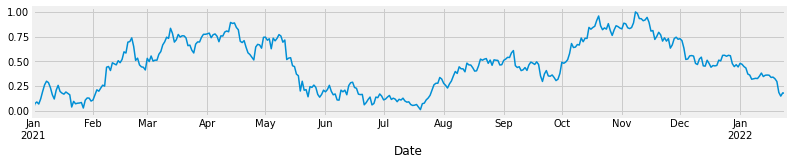

In [208]:
results.observed.plot(figsize=(12,2))

In [211]:
train_len = int(len(datos.y1) * 0.7)
print('train len: ', train_len)
test_len = len(datos.y1) - train_len
print('test len: ',test_len)

train len:  273
test len:  117


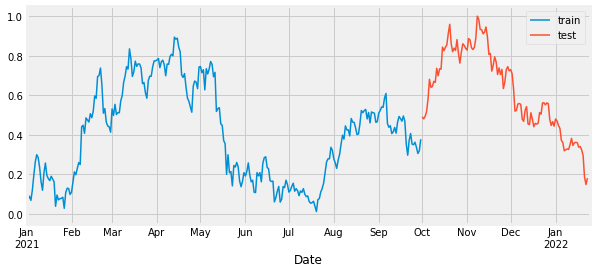

In [212]:
# Separación datos train-test
# ==============================================================================
#steps = 36
steps = test_len
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

fig, ax = plt.subplots(figsize=(9, 4))
datos_train['y1'].plot(ax=ax, label='train')
datos_test['y1'].plot(ax=ax, label='test')
ax.legend();

In [238]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 1
             )

forecaster.fit(y=datos_train['y1'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1] 
Window size: 1 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2021-01-01 00:00:00'), Timestamp('2021-09-30 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-01-24 22:33:51 
Last fit date: 2022-01-24 22:33:51 
Skforecast version: 0.4.2 

In [239]:
# Predicciones
# ==============================================================================
#steps = 36
steps = test_len
predicciones = forecaster.predict(steps=steps)
predicciones.head(5)

2021-10-01    0.427048
2021-10-02    0.404385
2021-10-03    0.433648
2021-10-04    0.408067
2021-10-05    0.453539
Freq: D, Name: pred, dtype: float64

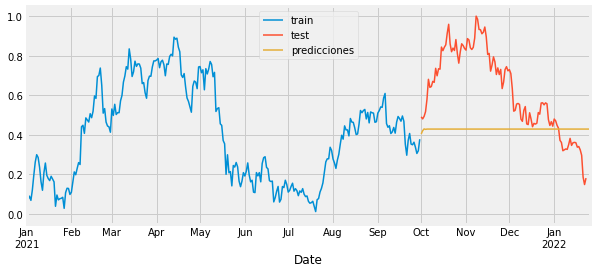

In [253]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['y1'].plot(ax=ax, label='train')
datos_test['y1'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [241]:
# Error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['y1'],
                y_pred = predicciones
            )
print(f"Error de test (mse): {error_mse}")

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [248]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 1 # Este valor será remplazado en el grid search
             )

# Hiperparámetros del regresor
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

# Lags utilizados como predictores
lags_grid = [1,2,3]

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos_train['y1'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 10,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)*0.7),
                        return_best        = True,
                        verbose            = False
                   )

Number of models compared: 18


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:37<00:00, 12.60s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2] 
  Parameters: {'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 0.016826565946508585



In [249]:
# Resultados Grid Search
# ==============================================================================
resultados_grid

,lags,params,metric,max_depth,n_estimators
9,"[1, 2]","{'max_depth': 5, 'n_estimators': 500}",0.016827,5,500
11,"[1, 2]","{'max_depth': 10, 'n_estimators': 500}",0.017128,10,500
14,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 100}",0.017140,5,100
3,[1],"{'max_depth': 5, 'n_estimators': 500}",0.017300,5,500
8,"[1, 2]","{'max_depth': 5, 'n_estimators': 100}",0.017439,5,100
2,[1],"{'max_depth': 5, 'n_estimators': 100}",0.017571,5,100
15,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 500}",0.017622,5,500
16,"[1, 2, 3]","{'max_depth': 10, 'n_estimators': 100}",0.017728,10,100
4,[1],"{'max_depth': 10, 'n_estimators': 100}",0.018201,10,100
10,"[1, 2]","{'max_depth': 10, 'n_estimators': 100}",0.018809,10,100


In [250]:
# Crear y entrenar forecaster con mejores hiperparámetros
# ==============================================================================
regressor = RandomForestRegressor(max_depth=5, n_estimators=500, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 2
             )
forecaster.fit(y=datos_train['y1'])

In [251]:
# Predicciones
# ==============================================================================
#steps = 36
steps = test_len + 1
predicciones = forecaster.predict(steps=steps)
#print(predicciones.index)
min_max_scaler.fit(datos['y'].values.reshape(-1, 1))

#use the inverse transform to get the original values
pred = min_max_scaler.inverse_transform(predicciones.values.reshape(-1, 1))
preds = pd.DataFrame(pred, columns=['y'])
preds.index = predicciones.index
print('precio mes proximo: ', preds.iloc[-1])


precio mes proximo:  y    45748.315124
Name: 2022-01-26 00:00:00, dtype: float64


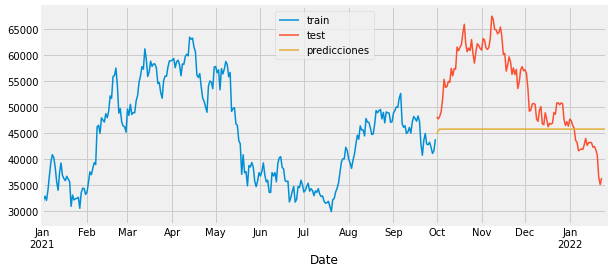

In [252]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
preds['y'].plot(ax=ax, label='predicciones')
ax.legend();